# Bayesian Analysis 

This notebook is a support of the [Dynalist note](https://dynalist.io/d/JqoIHKCNcU3VsOQWgemyzCAJ) and from [Duke Lecture](https://people.duke.edu/~ccc14/sta-663/MCMC.html#)

This notebook goes through 3 part:

1. Define a simple Bayesian estimate
2. Use MCM to compute prior
3. Real data example

## Bayesian Estimate

In cases with conjugate priors (with conjugate priors, the posterior has the same distribution as the prior):

- we can get closed form solutions
- We can use numerical integration
- We can approximate the functions used to calculate the posterior with simpler functions and show that the resulting approximate posterior is “close” to true posteiror (variational Bayes)
- We can use Monte Carlo methods, of which the most important is Markov Chain Monte Carlo (MCMC)

We will use the toy example of estimating the bias of a coin given a sample consisting of n tosses to illustrate a few of the approaches.

In [0]:
#!pip install seaborn==0.9.0

In [0]:
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import scipy.stats as st

## Brief review scipy 

### Probability Density Function

#### `rvs`

`rvs` generates random number

Example, we can generate a normal distribution with 100 random points. It is helpful when we don't have data

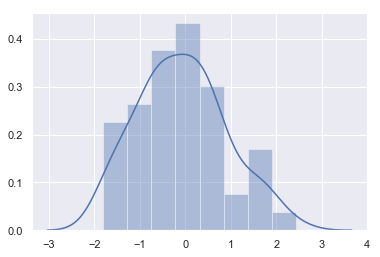

In [0]:
ex_1 = st.norm().rvs(100)
sns.distplot(ex_1)

#### `pdf`

We can generate the same graoh using a known dataset and `pdf`

Note, for a categorical function, we need to use the `pmf`

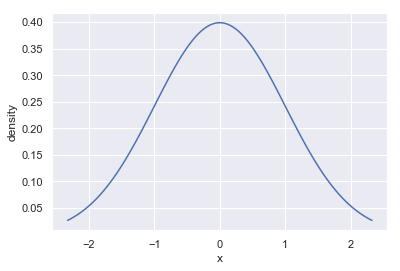

In [0]:
x = np.linspace(st.norm.ppf(0.01),
                st.norm.ppf(0.99), 100)
x_pdf = st.norm.pdf(x)
dic = {'x': x, 
      'density': x_pdf}
ex_2 = pd.DataFrame(dic)
sns.lineplot(x="x", y="density", data=ex_2)

### Cumulative distribution function

We can generate the probaility mass function using `cdf` fro Normal Density

$$
F(x)=\int_{-\infty}^{x} \frac{e^{-x^{2} / 2}}{\sqrt{2 \pi}}
$$

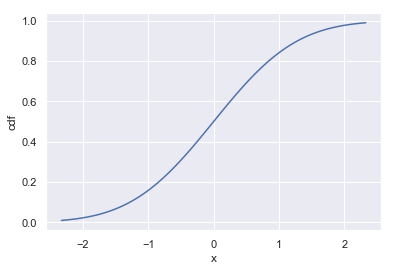

In [0]:
x_pmf = st.norm.cdf(x)
dic = {'x': x, 
       'pdf': x_pdf,
      'cdf': x_pmf}
ex_3 = pd.DataFrame(dic)
ex_3_plot = sns.lineplot(x="x", y="cdf", data=ex_3)

## Example

We toss 100 times the coins and got 61 heads

$$
\begin{array}{r}{\text { The probability mass function for binom is: }} \\ {f(k)=\left( \begin{array}{c}{n} \\ {k}\end{array}\right) p^{k}(1-p)^{n-k}}\end{array}
$$

In [0]:
n = 100
h = 61

a, b = 10, 10
prior = st.beta(a, b)
post = st.beta(h+a, n-h+b)
thetas = np.linspace(0, 1, 200)

### Analytical solution

Compute:
- prior pdf
- likelihood pdf
- posterior pdf

In this case, the posterior is like an 'average' between prior and likelihood


In [0]:
x_axis = pd.Series(thetas, name = 'x_axis')
prior_pdf = pd.Series(prior.pdf(thetas), name = 'prior')
likelihood_pdf = pd.Series(n * st.binom(n, thetas).pmf(h), name = 'likelihood')
posterior_pdf = pd.Series(post.pdf(thetas), name = 'posterior')
frames = [x_axis, prior_pdf, likelihood_pdf, posterior_pdf]
df_ana = pd.concat(frames, axis=1).melt(id_vars=['x_axis'],
                                                      var_name='state',
                                                      value_name='proba')

Text(0.5, 0, '$\\theta$')

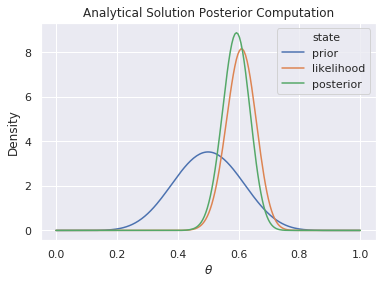

In [0]:
index = sns.lineplot(x="x_axis",
                     y="proba",
                     hue="state",
                     data=df_ana)
index.set_title('Analytical Solution Posterior Computation')
index.set_ylabel('Density')
index.set_xlabel(r'$\theta$')

## Metropolis-Hastings sampler

![](https://dynalist.io/u/paxrpRjzwLLZLun3LtrpQDaP/Metropolis_Hastings.png)

In [0]:
def posterior(theta):
	"""
	θ = theta
	If ρ≥1, then set θ=θp
	If ρ<1, then set θ=θp with probability ρ,
	otherwise set θ=θ (this is where we use the standard uniform distribution)
	Here, we choose the binomial distriution as the likelihood
	the prior is defined by the beta distribution
  The posterior is computed as follow:
  posterior ∝ likelihood × prior
	"""
	if theta < 0 or theta > 1:
		posterior =  0
	else:
		posterior = st.binom(n,theta).pmf(h) * st.beta(a, b).pdf(theta)
	return posterior

def r_rho(posterior_new, posterior_current):
	"""
	the function computes rho and return the minimum of the ratio.
	"""
	ratio = posterior_new/posterior_current
	rho = min(1, ratio)
	return ratio

def Metropolis_Hastings(iteration, theta, sigma):
  """
  Computes the samplings distribution using the Metropolis Hastings algorithm
  the objective is to determine the best value of theta, for a given sigma
  the prior distribution is a beta pdf
  the likelihood function is a binomial
  
  Step 1: Compute a new theta for the transition model,
  following a normal distribution
  Step 2: Compute the ratio ie. acceptance formula
  Step 3: Store the thetas. Only those lower than the random variable u 
  are accepted
  """
  store_simulation = {
		'theta': [theta],
		'status' : [False]
		}
  for i in range(iteration):
	### Condition to accept new theta
	#We accept a proposed move to θk+1 whenever the density of the (unnormalzied)
	#target distribution at θk+1 is larger than the value of θk
	### Choose a new proposed value
    theta_new = theta + st.norm(0, sigma).rvs()
	### Compute rho: takes the lowest value of the ratio
    rho =  r_rho(posterior(theta_new), posterior(theta))
	### Generate a random variable
    u = np.random.uniform()
	### test if r < rho, the set new theta
    store_simulation['theta'].append(theta_new)
    if u < rho:
      theta = theta_new
      store_simulation['status'].append(True)
    else:
      store_simulation['status'].append(False)
  return store_simulation

In [0]:
simul  = Metropolis_Hastings(iteration = 1000, theta = 0.1, sigma = 0.3)

In [0]:
df_simul = pd.DataFrame(simul)
df_simul.groupby('status')['status'].count()

status
False    804
True     197
Name: status, dtype: int64

#### Plot graph

1. First 50 sampling

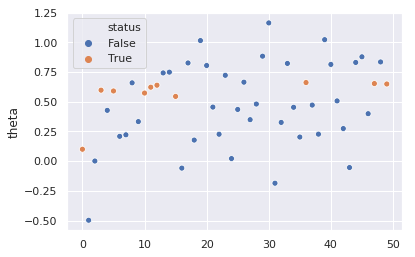

In [0]:
ax = sns.scatterplot(x=df_simul.iloc[:50,:].index,
					  y="theta", hue="status",
					   data=df_simul.iloc[:50,:])

2. All samples

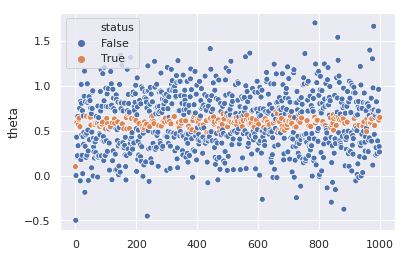

In [0]:
ax = sns.scatterplot(x=df_simul.index,
					  y="theta", hue="status",
					   data=df_simul)

So, starting from an initial σ of 0.1, the algorithm converged pretty quickly to the expected value of 6. 

Let's try with different theta

In [0]:
sampless = [Metropolis_Hastings(iteration = 100, theta = theta, sigma = 0.3) for theta in np.arange(0.1, 1, 0.2)]

In [0]:
appended_data = []
for theta in np.arange(0.1, 1, 0.2):
  df_sim = pd.DataFrame(Metropolis_Hastings(iteration = 100,
                                            theta = theta,
                                            sigma = 0.05))
  df_sim['value_theta'] = theta
  df_sim = df_sim.reset_index()
  appended_data.append(df_sim)

df_sims = pd.concat(appended_data)

Text(0.5, 0, 'Iterations')

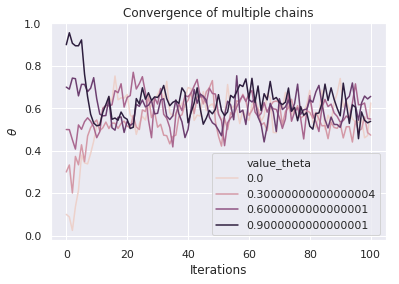

In [0]:
index = sns.lineplot(x="index",
                     y="theta",
                     hue="value_theta",
                     data=df_sims)
index.set_title('Convergence of multiple chains')
index.set_ylabel(r'$\theta$')
index.set_xlabel('Iterations')

3 Trace

Still, we will consider the initial 25% of the values of σ to be “burn-in”, so we drop them.

Text(0.5, 0, 'Iterations')

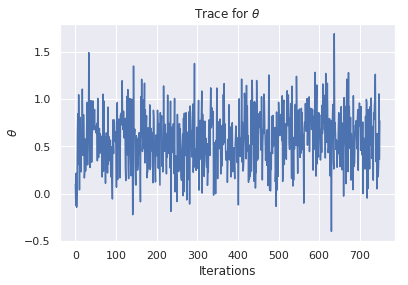

In [0]:
df_75 =  df_simul.iloc[:750, :]
index = sns.lineplot(x=df_75.index,
                     y="theta",
                     data=df_75)
index.set_title('Trace for ' + r'$\theta$')
index.set_ylabel(r'$\theta$')
index.set_xlabel('Iterations')

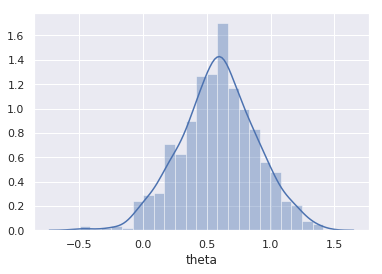

In [0]:
ax = sns.distplot(df_75.theta)

## Example with normal distribution

Lets generate some data: 20 points from a normal centered around zero. 

Our goal will be to estimate the posterior of the mean $\mu$ (we'll assume that we know the standard deviation to be 1)



[Text(0.5,0,'x'), Text(0.5,1,'Histogram of observed data')]

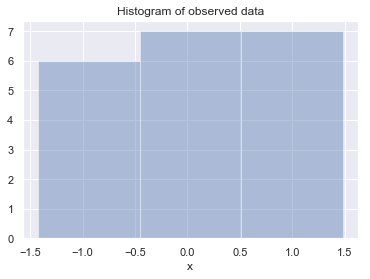

In [0]:
data = np.random.randn(20)
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
ax.set(title='Histogram of observed data', xlabel='x')
           

1. Define the likelihood 

We have to define our model. In this simple case, we will assume that this data is **normal distributed**, i.e. the likelihood of the model is normal

For each parameter we want to infer, we have to chose a prior. For simplicity, lets also assume a **Normal distribution** as a prior for $\mu$. 

Thus, in stats speak our model is:

$$
\begin{aligned} \mu & \sim \text { Normal( }(0,1) \\ x|\mu& \sim \operatorname{Normal}(x ; \mu, 1) \end{aligned}
$$

What is convenient, is that for this model, we actually can compute the posterior analytically. 

That's because for a **normal likelihood with known standard deviation**, the normal prior for $\mu$ is conjugate

- conjugate here means that our posterior will follow the same distribution as the prior

So we know that our posterior for $\mu$  is also normal

![1.png](https://dynalist.io/u/d-tGsJLSvpTBRhm854Zi1TwI)

The posterior is computed as follown when the variane is known

$$
\frac{1}{\frac{1}{\sigma_{0}^{2}}+\frac{n}{\sigma^{2}}}\left(\frac{\mu_{0}}{\sigma_{0}^{2}}+\frac{\sum_{i=1}^{n} x_{i}}{\sigma^{2}}\right),\left(\frac{1}{\sigma_{0}^{2}}+\frac{n}{\sigma^{2}}\right)^{-1}
$$

In [0]:
def posterior(data, x, mu_0, sigma_0):
    """
    compute the posterior with known variance
    cf above for the formula
    """
    sigma = 1
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return st.norm(mu_post, np.sqrt(sigma_post)).pdf(x)

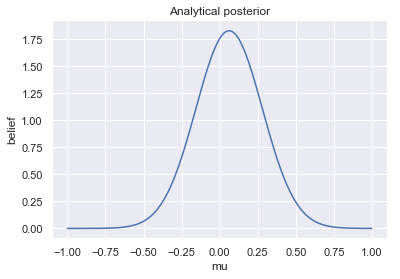

In [0]:
ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = posterior(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

This shows our quantity of interest, the probability of μ's values after having seen the data, taking our prior information into account.

Lets assume, however, that our prior wasn't conjugate and we couldn't solve this by hand which is usually the case

## MCMC sampling 

1. Compute a proposal: random variable drawn from normal density. 

At first, you find starting parameter position (can be randomly chosen), lets fix it arbitrarily to: $\mu_{current} = 1$

Then, you propose to move (jump) from that position somewhere else (that's the Markov part)

You can be very dumb or very sophisticated about how you come up with that proposal

The **Metropolis sampler** is very dumb and just takes a sample from a normal distribution (no relationship to the normal we assume for the model) centered around your current $\mu$ value (i.e. mu_current) with a certain standard deviation (proposal_width) that will determine how far you propose jumps 

This rule consists of a proposal density, which simulates a can didate value $\theta^*$ , and the computation of an acceptance probability $P$,  which indicates the probability that the candidate value will be accepted as the next value in the sequence.

The proposal, therefore, is a random variable drawn from normal density. 

2. Compute the likelihood ratio

Next, you evaluate whether that's a good place to jump to or not. 

If the resulting normal distribution with that proposed $\mu$ explaines the data better than your old $\mu$, you'll definitely want to go there.

What does "explains the data better" mean? 

- We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed mu and a fixed sigma = 1).
- This can easily be computed by calculating the probability for each data point
- Then multiplying the individual probabilities, i.e. compute the likelihood (usually you would use log probabilities)

$$
R=\frac{g\left(\theta^{*}\right) p\left(\theta^{t-1} | \theta^{*}\right)}{g\left(\theta^{t-1}\right) p\left(\theta^{*} | \theta^{t-1}\right)}
$$

remember posterior ∝ likelihood × prior

In [0]:
def posterior(mu_current, mu_proposal):
	"""
	function compute the nominator and denominator of the equation is step 2
	that is, the prior is equal to likelihood * prior
	both are following a normal distribution
	"""
	#mu_current = 1.
	## 1) Compute the likelihood

	likelihood_current = st.norm(mu_current, 1).pdf(data).prod()
	likelihood_proposal = st.norm(mu_proposal, 1).pdf(data).prod()

	# Compute prior probability of current and proposed mu        
	prior_current = st.norm(0, 1).pdf(mu_current)
	prior_proposal = st.norm(0, 1).pdf(mu_proposal)

	# Nominator of Bayes formula
	p_current = likelihood_current * prior_current
	p_proposal = likelihood_proposal * prior_proposal
	dic_proposal = {
			'current': p_current,
			'proposal': p_proposal
	}
	return dic_proposal

def r_rho(dic_proposal):
	"""
	the function computes rho and return the minimum of the ratio.
	"""
	p_accept = dic_proposal['proposal'] / dic_proposal['current'] 
	rho = min(1, p_accept)
	return rho

def Metropolis(iteration, mu):
	"""
	Computes the samplings distribution using the Metropolis algorithm
	the objective is to determine the best value of mu, for a given sigma
	the prior distribution is a norma pdf
	the likelihood function is a norma
	
	Step 1: Compute a new mu for the transition model,
	following a normal distribution
	Step 2: Compute the ratio ie. acceptance formula
	Step 3: Store the mu. Only those lower than the random variable u 
	are accepted
	"""
	store_simulation = {
		'mu': [mu],
		'status' : [False]
		}
	for i in range(iteration):
	### Condition to accept new theta
	#We accept a proposed move to θk+1 whenever the density of the (unnormalzied)
	#target distribution at θk+1 is larger than the value of θk
	### Choose a new proposed value
	## 1) define proposal
		proposal = st.norm(mu).rvs()
		mu_proposal = mu + proposal
	## 2) compute the ratio
		dic_r = posterior(mu, mu_proposal)
	### Compute rho: takes the lowest value of the ratio
		rho =  r_rho(dic_r)
	### Generate a random variable
		u = np.random.uniform()
	### test if r < rho, the set new theta
		store_simulation['mu'].append(mu_proposal)
		if u < rho:
			mu = mu_proposal
			store_simulation['status'].append(True)
		else:
			store_simulation['status'].append(False)
	return store_simulation

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the `mu_proposal` has higher likelihood than mu_current. 

Eventually we'll get to $\mu = 0$ (or close to it) from where no more moves will be possible. However, we want to get a posterior so we'll also have to sometimes accept moves into the other direction. 

The key trick is by dividing the two probabilities.

3. Compute the acceptance probability $P=\min \{R, 1\}$

we get an acceptance probability. You can already see that if `p_proposal` is larger, that probability will be > 1 and we'll definitely accept.

However, if `p_current` is larger, say twice as large, there'll be a 50% chance of moving there

In [0]:
simulation = Metropolis(iteration = 1000, mu = 1)
df_simul = pd.DataFrame(simulation)
df_simul.groupby('status')['status'].count()

status
False    763
True     238
Name: status, dtype: int64

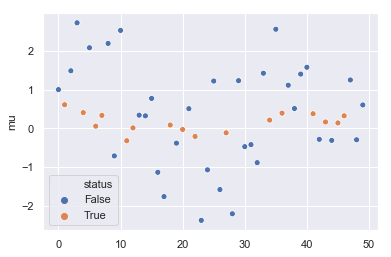

In [0]:
ax = sns.scatterplot(x=df_simul.iloc[:50,:].index,
					  y="mu", hue="status",
					   data=df_simul.iloc[:50,:])

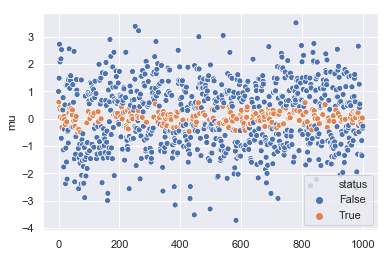

In [0]:
ax = sns.scatterplot(x=df_simul.index,
					  y="mu", hue="status",
					   data=df_simul)

### Distribution $\mu$

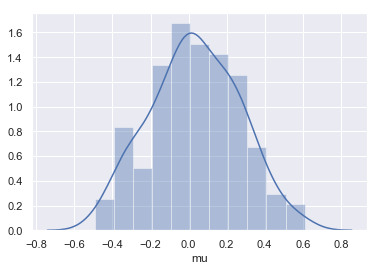

In [0]:
true_mu = df_simul[df_simul['status'] == True]
sns.distplot(true_mu.mu)

## Example StanFord Heartplant

Example from [R for Bayes](https://web.kamihq.com/web/viewer.html?state=%7B%22ids%22:%5B%221e221kgkS-AYavaSkxGyMORCxi6qralT6%22%5D,%22action%22:%22open%22,%22userId%22:%22100006339688710166679%22%7D)

One of the inferential goals is to decide if heart transplantation extends a patient’s life.

**Pareto Model**

- assumes individual patients in the nontransplant group have exponential lifetime distributions with mean $1/\theta$
  - $\theta$ is drawn from gamma and vary between patients
  
  $$
f(\theta)=\frac{\lambda^{p}}{\Gamma(p)} \theta^{p-1} \exp (-\lambda \theta)
$$

- Patients in the transplant group have a similar exponential lifetime distribu-tion, where the mean is $1/(θτ)$
- $\tau$ is the risk of death, $\tau>0$. if $\tau = 0$ there is no risk
- Suppose the survival times ${x_i}$ are observed for $N$ nontransplant patients
- For the M patients that have a heart transplant, let $y_j$ and $z_j$ denote the time to transplant and survival time
- $m$ of these patients died during the study.

Objective
- **The unknown parameter vector is $(τ, λ, p)$**

**Likelihood function**

$$
\begin{aligned} L(\tau, \lambda, p) & \propto \prod_{i=1}^{n} \frac{p \lambda^{p}}{\left(\lambda+x_{i}\right)^{p+1}} \prod_{i=n+1}^{N}\left(\frac{\lambda}{\lambda+x_{i}}\right)^{p} \\ \times \prod_{j=1}^{m} \frac{\tau p \lambda^{p}}{\left(\lambda+y_{j}+\tau z_{j}\right)^{p+1}} & \prod_{j=m+1}^{M}\left(\frac{\lambda}{\lambda+y_{j}+\tau z_{j}}\right)^{p} \end{aligned}
$$

- all the parameters are positive.
- Suppose we place a uniform prior on $(τ, λ, p)$, so the posterior density is proportional to the likelihood. 
- we transform the parameters by logs: 
  - $\theta_{1}=\log \tau, \theta_{2}=\log \lambda, \theta_{3}=\log p$

**posterior density**

$$
g(\theta | \text { data }) \propto L\left(\exp \left(\theta_{1}\right), \exp \left(\theta_{2}\right), \exp \left(\theta_{3}\right)\right) \prod_{i=1}^{3} \exp \left(\theta_{i}\right)
$$

dataset

for each patient, there are four variables: 
- `survtime`, the survival time
- `transplant`, a variable that is 1 or 0 depending on whether the patient had a transplant or not
- `timetotransplant`, the time a transplant patient waits for the operation
- `state`, a variable that indicates if the survival time was censored (0 if the patient died and 1 if he was still alive)

- The numbers of nontransplant and transplant patients are denoted by N and M
- We divide the data into two groups using the transplant indicator variable t
- For the nontransplant patients, 
  - `xnt`: the survival times
  - `dnt`:censoring indicators
- for the transplant patients
  - `y`: waiting times
  - `z`: survival times,
  - `dt`: censoring


In [43]:
heart = pd.read_csv("/Users/Thomas/Downloads/heart.csv")
heart.head()

,Unnamed: 0,survtime,transplant,timetotransplant,state
0,1,49,0,0,0
1,2,5,0,0,0
2,3,17,0,0,0
3,4,2,0,0,0
4,5,39,0,0,0


In [0]:
## define parameters
x = heart.survtime 
y = heart.timetotransplant  
t = heart.transplant 
d = heart.state 

## Non transplant patient
xnt = heart[heart['state'] == 0]['survtime']
dnt = heart[heart['transplant'] == 0]['state']


## transplant patient
z = heart[heart['state'] == 1]['survtime']
y = heart[heart['state'] == 1]['timetotransplant']
dt = heart[heart['transplant'] == 1]['state']


In [44]:
# Non transplanted
## Group 1: Non transplanted who died
### transplant = 0 and state = 0
## Group 2: Non transplanted who are alive
### transplant = 0 and state = 1
# transplanted
## Group 3:  transplanted who died
### transplant = 1 and state = 1
## Group 3:  transplanted who are alive
### transplant = 1 and state = 0

conditions = [
    (heart['transplant'] == 0) & (heart['state'] == 0),
    (heart['transplant'] == 0) & (heart['state'] == 1),
    (heart['transplant'] == 1) & (heart['state'] == 0),
    (heart['transplant'] == 1) & (heart['state'] == 1)
  ]
choices = ['g1', 'g2', 'g3', 'g4']
heart['group'] = np.select(conditions, choices, default=1)
dummy_g = pd.get_dummies(heart['group'])
heart = pd.concat([heart, dummy_g], axis = 1)
heart.head()

,Unnamed: 0,survtime,transplant,timetotransplant,state,group,g1,g2,g3,g4
0,1,49,0,0,0,g1,1,0,0,0
1,2,5,0,0,0,g1,1,0,0,0
2,3,17,0,0,0,g1,1,0,0,0
3,4,2,0,0,0,g1,1,0,0,0
4,5,39,0,0,0,g1,1,0,0,0


1. Define the posterior density

We use log likelihood

$$
\begin{aligned} L(\tau, \lambda, p) & \propto \prod_{i=1}^{n} \frac{p \lambda^{p}}{\left(\lambda+x_{i}\right)^{p+1}} \prod_{i=n+1}^{N}\left(\frac{\lambda}{\lambda+x_{i}}\right)^{p} \\ \times \prod_{j=1}^{m} \frac{\tau p \lambda^{p}}{\left(\lambda+y_{j}+\tau z_{j}\right)^{p+1}} & \prod_{j=m+1}^{M}\left(\frac{\lambda}{\lambda+y_{j}+\tau z_{j}}\right)^{p} \end{aligned}
$$

**Log- likelihood**

Non transplanted

$$ L_{nt} =  \sum_{i = 1}^n (log(p) + p * log(\lambda) - (p+1) + log(\lambda + x_i)) + \sum_{i = n+1}^N (p * log(\lambda / (\lambda + x_i)))$$

Transplanted

$$ L_t = \sum_{j = 1}^m (p * log(\lambda) - log(p * \tau) - (p +1) * log(\lambda + y_j + \tau * z_j)) + \sum_{j = m +1}^M (p * log(\lambda /(\lambda + y_j + \tau * z_j)))$$

**Posterior density**

 $\sum L_{nt} + \sum L_t + \theta_1 + \theta_2 + \theta_3$


In [38]:
heart.head()

,Unnamed: 0,survtime,transplant,timetotransplant,state,group,1,2,3,4
0,1,49,0,0,0,1,1,0,0,0
1,2,5,0,0,0,1,1,0,0,0
2,3,17,0,0,0,1,1,0,0,0
3,4,2,0,0,0,1,1,0,0,0
4,5,39,0,0,0,1,1,0,0,0


In [0]:
def likelihood(dic_param, option = 'current'):
  
  lmbda = np.exp(dic_param['lambda'][option])
  p = np.exp(dic_param['p'][option])
  tau =np.exp(dic_param['tau'][option])
  
  #print(lmbda, p, tau)
  
  l_nt = np.sum((p * np.log(lmbda) + np.log(p) - (p + 1) * \
  np.log(lmbda + heart['survtime'])) * heart['g1'] + \
  (p * np.log(lmbda / (lmbda + heart['survtime']))) * heart['g2'])

  l_t = np.sum((p * np.log(lmbda) - np.log(p * tau) - (p + 1) * np.log(lmbda + \
       heart['timetotransplant'] + tau * heart['survtime'])) * heart['g3'] + \
  (p * np.log(lmbda / (lmbda + heart['timetotransplant'] + tau * \
  heart['survtime']))) * heart['g4'])
  dic_likelihood = {
      'l_nt' : l_nt,
      'l_t' : l_t
  }
  return dic_likelihood

In [0]:
def posterior(dic_param):
	"""
	function compute the nominator and denominator of the equation is step 2
	that is, the prior is equal to likelihood * prior
	both are following a normal distribution
	"""
	
	
	for x in ['current', 'proposed']:
		
		lmbda = dic_param['lambda'][x]
		p = dic_param['p'][x]
		tau = dic_param['tau'][x]
		
		if x == 'current':
			theta_current = {
			'theta_1' : lmbda, 
			'theta_2' : p, 
			'theta_3' : tau
			}
		else:
			theta_proposed = {
			'theta_1' : lmbda, 
			'theta_2' : p, 
			'theta_3' : tau
			}
	
	#mu_current = 1.
	## 1) Compute the log likelihood
	
	likelihood_current = likelihood(dic_param, option = 'current')
	likelihood_proposal = likelihood(dic_param, option  = 'proposed')
	
	#likelihood_current = st.norm(mu_current, 1).pdf(data).prod()
	#likelihood_proposal = st.norm(mu_proposal, 1).pdf(data).prod()
	
		# Nominator of Bayes formula
	#p_current = likelihood_current * prior_current
	#p_proposal = likelihood_proposal * prior_proposal
			
	p_current = likelihood_current['l_nt'] + likelihood_current['l_t'] + \
	            theta_current['theta_1'] + theta_current['theta_2'] + \
	            theta_current['theta_3']
	
	
	p_proposal = likelihood_proposal['l_nt'] + likelihood_proposal['l_t'] + \
	            theta_proposed['theta_1'] + theta_proposed['theta_2'] + \
	            theta_proposed['theta_3']


	dic_proposal = {
			'current': p_current,
			'proposal': p_proposal
	}
	return dic_proposal

In [478]:
np.random.uniform(0,1)

0.648595228190815

In [0]:
def r_rho(dic_proposal):
	"""
	the function computes rho and return the minimum of the ratio.
	"""
	rho = dic_proposal['proposal'] - dic_proposal['current']
	if rho > 0:
		result = True
	else:
		u = np.random.uniform(0,1)
		rho_exp = np.exp(rho)
		if u < rho_exp:
			result = True
		else:
			result = False
	return result

def Metropolis(iteration, dic_params, sigma):
	"""
	Computes the samplings distribution using the Metropolis algorithm
	the objective is to determine the best value of mu, for a given sigma
	the prior distribution is a norma pdf
	the likelihood function is a norma
	
	Step 1: Compute a new mu for the transition model,
	following a normal distribution
	Step 2: Compute the ratio ie. acceptance formula
	Step 3: Store the mu. Only those lower than the random variable u 
	are accepted
	"""
	lmbda = np.exp(dic_param['lambda']['current'])
	p = np.exp(dic_param['p']['current'])
	tau = np.exp(dic_param['tau']['current'])
	### We want to store the exponential of the theta
	store_simulation = {
		'lambda': [lmbda],
		 'p': [p],
		 'tau': [tau] ,
		'status' : [False]
		}
	for i in range(iteration):
	### Condition to accept new theta
	#We accept a proposed move to θk+1 whenever the density of the (unnormalzied)
	#target distribution at θk+1 is larger than the value of θk
	### Choose a new proposed value
	## 1) define proposal
		for x in ['lambda', 'tau', 'p']:
			var = dic_param[x]['current']
			if x == 'lambda':
				proposal = np.random.normal(0, sigma['lambda']) 
			elif x == 'tau':
				proposal = np.random.normal(0, sigma['other'])
			else:
				proposal = np.random.normal(0, sigma['other'])
			#print(x, '\n', var, '\n', var + proposal)
			dic_param[x].update({'proposed': proposal + var})
	## 2) compute the ratio
		dic_r = posterior(dic_param)
	### Compute rho: takes the lowest value of the ratio
		rho =  r_rho(dic_r)
	### Generate a random variable
		#u = np.random.uniform()
	### test if r < rho, the set new theta
	
		lmbda = np.exp(dic_param['lambda']['proposed'])
		p = np.exp(dic_param['p']['proposed'])
		tau = np.exp(dic_param['tau']['proposed'])
		
		for x in ['lambda', 'tau', 'p']: 
			if x == 'lambda':
				store_simulation[x].append(lmbda)
			elif x == 'tau':
				store_simulation[x].append(tau)
			else:
				store_simulation[x].append(p)
		
		if rho:
			for x in ['lambda', 'tau', 'p']:
				new = dic_param[x]['proposed']
				dic_param[x].update({'current': new})
			store_simulation['status'].append(True)
		else:
			store_simulation['status'].append(False)
	return store_simulation

In [434]:
new = 3
for i in range(0, 10):
  p = st.norm(0,0.3).rvs()
  new = new + p
  print(new)

3.172912840233483
3.071416215128635
3.207532330893309
2.9159737340488068
3.528849206865466
3.3194016635210923
3.3445619353480427
3.284474608449994
3.277260164739444
3.729609193272454


status
False    4
True     7
Name: status, dtype: int64


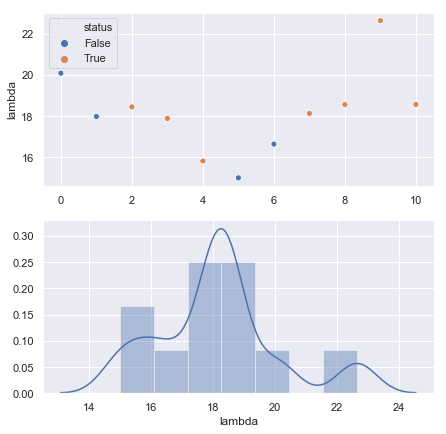

In [481]:
dic_param = {
    'lambda' : { 'current': 3, 
                 'proposed': 3}, 
    'tau' :    { 'current': 0, 
                 'proposed':0},
    'p' :      { 'current': -1, 
                 'proposed': -1}
}

sigma  = {
    'lambda': 0.1,
    'other': 0.3
}

simulation = Metropolis(iteration = 10, dic_params= dic_param, sigma = sigma)
df_simul = pd.DataFrame(simulation)
print(df_simul.groupby('status')['status'].count())

fig, axes =plt.subplots(2,1, figsize=(7, 7))
ax = sns.scatterplot(x=df_simul.index,
						y="lambda", hue="status",
						data=df_simul, 
						ax=axes[0])

ax = sns.distplot(df_simul['lambda'], ax=axes[1])

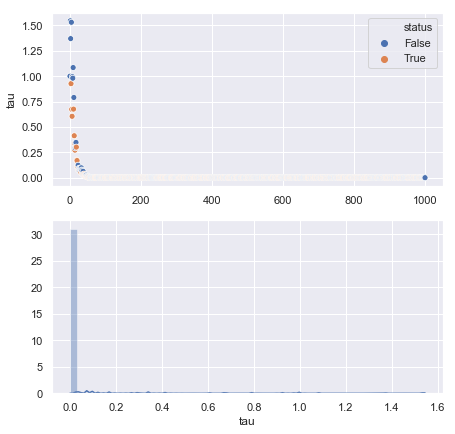

In [454]:
fig, axes =plt.subplots(2,1, figsize=(7, 7))
ax = sns.scatterplot(x=df_simul.index,
						y="tau", hue="status",
						data=df_simul, 
						ax=axes[0])

ax = sns.distplot(df_simul['tau'], ax=axes[1])

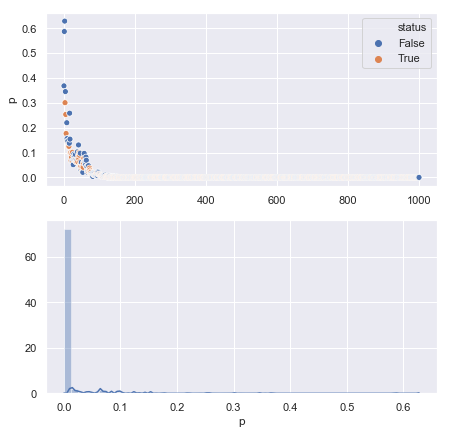

In [455]:
fig, axes =plt.subplots(2,1, figsize=(7, 7))
ax = sns.scatterplot(x=df_simul.index,
						y="p", hue="status",
						data=df_simul, 
						ax=axes[0])

ax = sns.distplot(df_simul['p'], ax=axes[1])

### Real Data Example

Need to double check with textbook. The example below comes from unsure [source](https://github.com/Joseph94m/MCMC/blob/master/MCMC.ipynb)

In [0]:
sunspot = pd.read_csv("http://www.sidc.be/silso/INFO/snmtotcsv.php", sep = ";" , 
            names = ['year', ' month', 'index_date', 'sunspot', 'a', 'b', 'c'])
sunspot['sunspot'] = sunspot['sunspot'] + 0.1
n = len(sunspot)
sunspot.shape

(3242, 7)

In [0]:
sunspot.head()

,year,month,index_date,sunspot,a,b,c
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


Text(0.5,0,'Years')

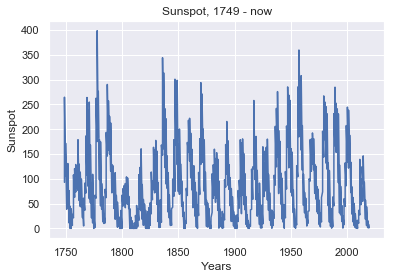

In [0]:
index = sns.lineplot(x="year",
                     y="sunspot",
                     data=sunspot, 
                    estimator=None)
index.set_title('Sunspot, 1749 - now')
index.set_ylabel('Sunspot')
index.set_xlabel('Years')

Text(0.5,0,'Years')

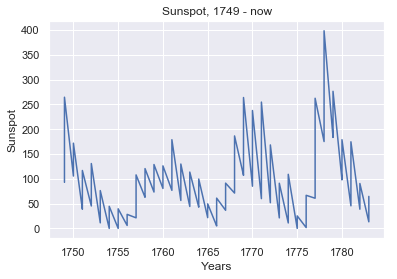

In [0]:
index = sns.lineplot(x="year",
                     y="sunspot",
                     data=sunspot.iloc[:420,:], 
                     estimator=None)
index.set_title('Sunspot, 1749 - now')
index.set_ylabel('Sunspot')
index.set_xlabel('Years')

#### Gamma distribution

we could model this phenomenon with a gamma distribution, with a new cycle resetting every 12 years

A gamma distribution Γ is a two-parameter family of continuous probability distributions

The parameters are the shape a and the scale b

A random variable X that is gamma-distributed is noted X~Γ(a, b), and in our case X is the count of sunspots.

The two parameters a and b are the unknowns that we would like to calculate distributions for.

![](https://upload.wikimedia.org/wikipedia/commons/e/e6/Gamma_distribution_pdf.svg)

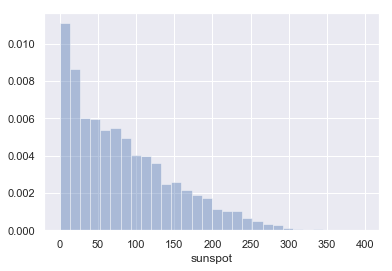

In [0]:
ax = sns.distplot(sunspot.sunspot, kde  = False, norm_hist = True)

### Test 

below, we test how to plot an histogram when the frequency is already computed. We need to duplicates the rows. For instance, if the frequency for 0 is 4, we need to duplicates four times the 0

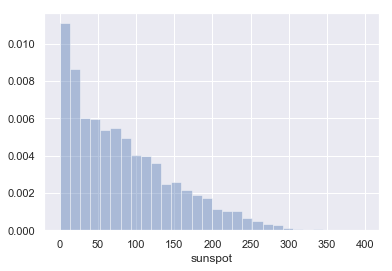

In [0]:
count_hist = pd.DataFrame(sunspot.groupby('sunspot')['sunspot'].count())
count_hist = count_hist.reindex(count_hist.index.repeat(count_hist.sunspot))
sns.distplot(count_hist.index, kde  = False, norm_hist = True)

For example, in the first cycle, the sunspot counts start from their highest at about 300 at the end of 1749, and fall to their lowest 6 years after, during 1755. Then the number rises up again to it’s maximum during 1761 and 1762 before falling again during 1766 and so on

The gamma distribution, has for PDF, f such that:

$$
f(x ; a, b)=\frac{b^{a} x^{a-1} e^{-b x}}{\Gamma(a)}
$$

Our prior, like in the example before, a and b must be strictly positive, we enforce this in the prior.

We will use the log likelihood of the gamma function to compute the posterior. 

we will log both the prior and the likelihood function. Why log? Simply because it helps with numerical stability, i.e. multiplying thousands of small values (probabilities, likelihoods, etc..) can cause an underflow in the system’s memory, and the log is a perfect solution because it transforms multiplications to additions and transforms small positive numbers into non-small negative numbers. 

We know the density follows a gamma distribution, but we don't the optimal parameter $a$ and $b$

Our initial guess for the Gamma parameters are $a = 4$ and $b = 10$. Clearly, it does not fit well

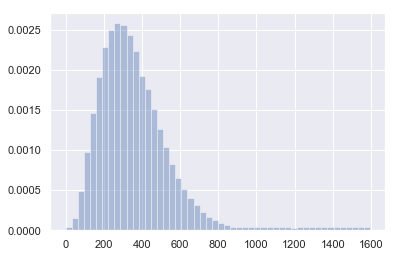

In [0]:
x_axis = sunspot.sunspot.sort_values(
    ascending = True).drop_duplicates().reset_index(drop = True)
x_pdf_gamma = st.gamma.pdf(x = x_axis,
                           a = 4,
                           loc = 0,
                           scale = 10) 
dic = {'x' : x_axis,
      'density': x_pdf_gamma, 
      'count_n' : n * x_pdf_gamma}
sun = pd.DataFrame(dic)
sun['count_n'] = sun['count_n'].astype('int')
sun = sun.sort_values(by = 'count_n', ascending  = False)
sun_zero = sun[sun['count_n'] == 0]
sun = sun.reindex(sun.index.repeat(sun.count_n))
sun = pd.concat([sun, sun_zero])
sns.distplot(sun.index, kde  = False, norm_hist = True)

### Update prior using Metropolis Hastings



In [0]:
def posterior_gamma(a, b):
	"""
	θ = theta
	If ρ≥1, then set θ=θp
	If ρ<1, then set θ=θp with probability ρ,
	otherwise set θ=θ (this is where we use the standard uniform distribution)
	Here, we choose the binomial distriution as the likelihood
	the prior is defined by the beta distribution
	The posterior is computed as follow:
	posterior ∝ likelihood × prior
	"""
	if a <= 0 or b <= 0:
	  x =  0
	else:
	  x = 1
	posterior = np.sum(st.gamma(
      a = a,
      scale = b,
      loc = 0).logpdf(sunspot.sunspot)) + np.log(x)
	return posterior

def r_rho(posterior_new, posterior_current):
	"""
	the function computes rho and return the minimum of the ratio.
	"""
	
	rho = posterior_new - posterior_current
	if rho > 0:
		result = True
	else:
		u = np.random.uniform(0,1)
		rho_exp = np.exp(rho)
		if u < rho_exp:
			result = True
		else:
			result = False
	return result

def Metropolis_Hastings(iteration, a,b):
  """
  Computes the samplings distribution using the Metropolis Hastings algorithm
  the objective is to determine the best value of theta, for a given sigma
  the prior distribution is a beta pdf
  the likelihood function is a binomial
  
  Step 1: Compute a new theta for the transition model,
  following a normal distribution
  Step 2: Compute the ratio ie. acceptance formula
  Step 3: Store the thetas. Only those lower than the random variable u 
  are accepted
  """
  store_simulation = {
		'a': [a],
	  'b': [b],
		'status' : [False]
		}
  for i in range(iteration):
	### Condition to accept new theta
	#We accept a proposed move to θk+1 whenever the density of the (unnormalzied)
	#target distribution at θk+1 is larger than the value of θk
	### Choose a new proposed value
	  a_new = np.absolute(np.random.normal(a,0.05))
	  b_new = np.absolute(np.random.normal(b,5))
	### Compute rho: takes the lowest value of the ratio
	  rho =  r_rho(posterior_gamma(a_new, b_new), posterior_gamma(a, b))
	### Generate a random variable
	  
	### test if r < rho, the set new theta
	  store_simulation['a'].append(a_new)
	  store_simulation['b'].append(b_new)
	  if rho:
	    a = a_new
	    b = b_new
	    store_simulation['status'].append(True)
	  else:
	    store_simulation['status'].append(False)
  return store_simulation

In [0]:
sim_gamma = Metropolis_Hastings(iteration = 1000, a = 4,b = 10)

In [0]:
df_simul = pd.DataFrame(sim_gamma)
df_simul.groupby('status')['status'].count()

status
False    819
True     182
Name: status, dtype: int64

### Postestimation graph

We can plot the first 50 draw

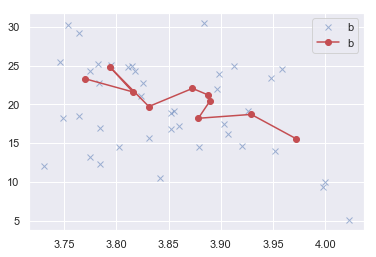

In [0]:
first_50 = df_simul.iloc[:50,:]
for key, grp in first_50.groupby('status'):
    if key == True:
      plt.plot(grp.a, grp.b, 'ro-')
    else:
      plt.plot(grp.a, grp.b, 'bx', alpha=0.5)
plt.legend(loc = 'best')

We can plot the last 50 draws

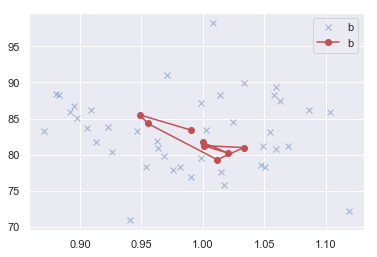

In [0]:
last_50 = df_simul.iloc[-50:,:]
for key, grp in last_50.groupby('status'):
    if key == True:
      plt.plot(grp.a, grp.b, 'ro-')
    else:
      plt.plot(grp.a, grp.b, 'bx', alpha=0.5)
plt.legend(loc = 'best')

We can plot all sample

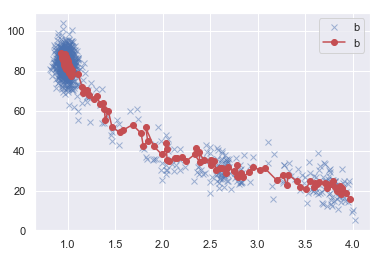

In [0]:
for key, grp in df_simul.groupby('status'):
    if key == True:
      plt.plot(grp.a, grp.b, 'ro-')
    else:
      plt.plot(grp.a, grp.b, 'bx', alpha=0.5)
plt.legend(loc = 'best')

### Trace of a and b

Keep only the last 50% of the true parameters. The first half is consired as the burn-in period

In [0]:
df_simul_true = df_simul[df_simul['status'] == True]
df_simul_true_50 = df_simul_true.iloc[-int(len(df_simul_true) * 0.5):,:]

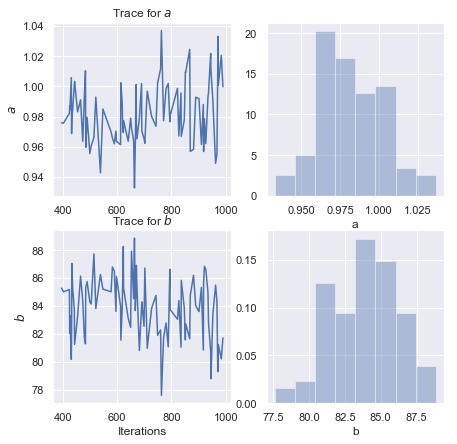

In [0]:
fig, axes =plt.subplots(2,2, figsize=(7, 7))
index = sns.lineplot(x=df_simul_true_50.index,
                     y="a",
                     data=df_simul_true_50, 
                     ax=axes[0, 0])
index.set_title('Trace for ' + r'$a$')
index.set_ylabel(r'$a$')

ax = sns.distplot(df_simul_true_50.a,
                 kde  = False,
                 norm_hist = True,
                 ax=axes[0, 1])

index = sns.lineplot(x=df_simul_true_50.index,
                     y="b",
                     data=df_simul_true_50, 
                     ax=axes[1, 0])
index.set_title('Trace for ' + r'$b$')
index.set_ylabel(r'$b$')
index.set_xlabel('Iterations')

ax = sns.distplot(df_simul_true_50.b,
                 kde  = False,
                 norm_hist = True,
                 ax=axes[1, 1])

### Prediction 

First, we average the last 50% of accepted samples of a and b, and we generate random individuals from a Γ distribution.  𝑎𝑎𝑣𝑒𝑟𝑎𝑔𝑒 =0.982107982022321 and  𝑏𝑎𝑣𝑒𝑟𝑎𝑔𝑒 =83.87382811645793

In [0]:
mean_a = df_simul_true_50.a.mean()
mean_b = df_simul_true_50.b.mean()
print(mean_a, mean_b)

0.9821079820223217 83.87382811645793


In [0]:
x_axis = np.linspace(0.1,500,50)
x_axis

array([1.00000000e-01, 1.03020408e+01, 2.05040816e+01, 3.07061224e+01,
       4.09081633e+01, 5.11102041e+01, 6.13122449e+01, 7.15142857e+01,
       8.17163265e+01, 9.19183673e+01, 1.02120408e+02, 1.12322449e+02,
       1.22524490e+02, 1.32726531e+02, 1.42928571e+02, 1.53130612e+02,
       1.63332653e+02, 1.73534694e+02, 1.83736735e+02, 1.93938776e+02,
       2.04140816e+02, 2.14342857e+02, 2.24544898e+02, 2.34746939e+02,
       2.44948980e+02, 2.55151020e+02, 2.65353061e+02, 2.75555102e+02,
       2.85757143e+02, 2.95959184e+02, 3.06161224e+02, 3.16363265e+02,
       3.26565306e+02, 3.36767347e+02, 3.46969388e+02, 3.57171429e+02,
       3.67373469e+02, 3.77575510e+02, 3.87777551e+02, 3.97979592e+02,
       4.08181633e+02, 4.18383673e+02, 4.28585714e+02, 4.38787755e+02,
       4.48989796e+02, 4.59191837e+02, 4.69393878e+02, 4.79595918e+02,
       4.89797959e+02, 5.00000000e+02])

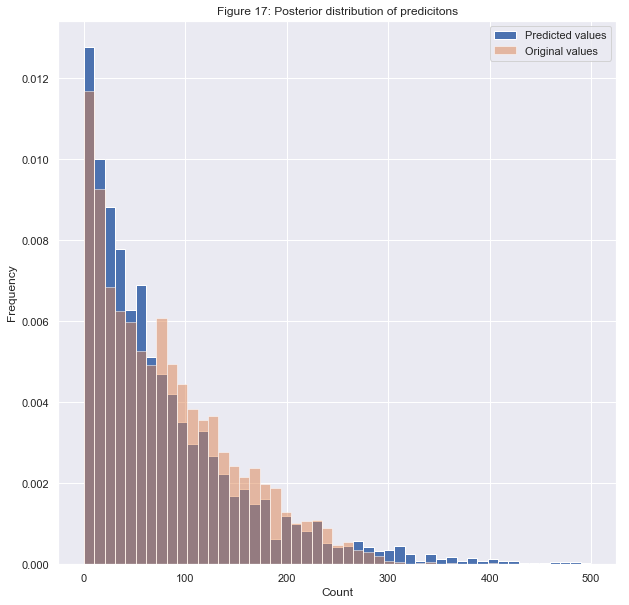

In [0]:
size = len(sunspot.sunspot)
prediction_gamma = st.gamma(a = mean_a, scale = mean_b).rvs(size=size)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

ax.hist(prediction_gamma,bins=np.linspace(0,500,50) ,density=True,label="Predicted values")
ax.hist(sunspot.sunspot,bins=np.linspace(0,500,50) ,alpha=0.5,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Figure 17: Posterior distribution of predicitons")
ax.legend()

# Example 2:

